In [1]:
import os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as euc_dist

In [2]:
def get_wv_df():
    wee_ves_dir = '/net/scratch/hanliu-shared/data/image-data/output/one-class_syn2_size-color-diff-2D'
    tsv_file = os.path.join(wee_ves_dir,'images-config.tsv')
    df = pd.read_table(tsv_file,delim_whitespace=True,header=None)
    df = df.rename(columns={0: "label", 
                    1: "name",
                    2: "index",
                    4: "bodyheadszratio",
                    5: "bodyheadcolordiff",
                    6: "bodysz",
                    7: "bodycolor",
                    8: "bodycolorlighter"
                    })
    features =  ["bodyheadszratio",
                "bodyheadcolordiff",
                "bodysz",
                "bodycolor",
                "bodycolorlighter"]
    def extract_feature(x):
        x_new= x.split('=')[1]
        return x_new
        
    for feature in features:
        df[feature] = df.apply(lambda row : extract_feature(row[feature]), axis = 1)
    for fea in features:
        df[fea] = df[fea].astype('float')

    return df

In [3]:
df = get_wv_df()
selected_features = ["bodyheadszratio", "bodyheadcolordiff"]
def return_label(w,b,x,y):
    return 1 if y > w*x+b else 0
w = -0.73027025
b = 0.68565111
df['pseudo_label'] = df.apply(lambda row : return_label(w,b,row[selected_features[0]],row[selected_features[1]]), axis = 1)
x, y = df[selected_features].values, df['pseudo_label'].values

In [4]:
def trans(x, y, w1=1, w2=1, theta=0, s1=0, s2=0, center=True):
    u = x.mean(0); x = x - u if center else x
    u0, u1 = x[y==0].mean(0), x[y==1].mean(0); u01 = u1 - u0
    theta = 0.5 * np.pi - np.arctan(u01[1] / u01[0]) if theta == 'hard' else theta
    theta = 0 - np.arctan(u01[1] / u01[0]) if theta == 'easy' else theta
    apply = lambda t, x: t.dot(x.T).T
    rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    stretch = np.array([[w1, s1], [s2, w2]])
    # trans = lambda x: apply(apply(stretch, rot), x) # rotate first
    trans = lambda x: apply(stretch, apply(rot, x)) # stretch first
    return trans(x) + u if center else trans(x)

def plot(x, xt, figsize=(13, 6), xlim=[-0.2, 1], ylim=[-0.2, 1]):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    ax[0].set_title('feature'); ax[1].set_title('human')
    ax[0].scatter(x[:,0][y==0], x[:,1][y==0])
    ax[0].scatter(x[:,0][y==1], x[:,1][y==1])
    ax[1].scatter(xt[:,0][y==0], xt[:,1][y==0])
    ax[1].scatter(xt[:,0][y==1], xt[:,1][y==1])
    ax[0].set_xlim(xlim); ax[1].set_xlim(xlim)
    ax[0].set_ylim(ylim); ax[1].set_ylim(ylim)
    return fig, ax

In [5]:
remb_train = pickle.load(open('../embeds/wv_old/RESN_train_emb10.pkl', 'rb'))
remb_valid = pickle.load(open('../embeds/wv_old/RESN_valid_emb10.pkl', 'rb'))
remb_test = pickle.load(open('../embeds/wv_old/RESN_test_emb10.pkl', 'rb'))

In [6]:
p2i_train = pickle.load(open('../data/weevil_vespula/p2i.pkl', 'rb'))
p2i_valid = pickle.load(open('../data/weevil_vespula/p2i_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../data/weevil_vespula/p2i_test.pkl', 'rb'))

In [7]:
i2p_train = {v:int(k) for k, v in p2i_train.items()}
i2p_valid = {v:int(k) for k, v in p2i_valid.items()}
i2p_test = {v:int(k) for k, v in p2i_test.items()}

In [8]:
def get_nn(dist):
    nn_ids = np.argsort(dist, 1)
    find_first = lambda ids, pool: [i for i in ids if i in pool][0]
    train_neg_ids = [i for i in i2p_train.keys() if y[i2p_train[i]] == 0]
    train_pos_ids = [i for i in i2p_train.keys() if y[i2p_train[i]] == 1]
    nn_i = np.array([[i, 
        find_first(nn_ids[i], train_neg_ids if y[i2p_test[i]] == 0 else train_pos_ids), # in-class 
        find_first(nn_ids[i], train_neg_ids if y[i2p_test[i]] == 1 else train_pos_ids)] # out-of-class
        for i in range(len(remb_test))])
    nn_p = np.array([[i2p_test[a], i2p_train[p], i2p_train[n]] for a, p, n in nn_i])
    return nn_i, nn_p

def eval(human, emb_nn_p):
    emb_nn_p = np.array(emb_nn_p) if type(emb_nn_p) == type([]) else emb_nn_p
    a, p, n = human[emb_nn_p[:, 0]], human[emb_nn_p[:, 1]], human[emb_nn_p[:, 2]]
    return np.diag(euc_dist(a, p)) < np.diag(euc_dist(a, n))

def eval_1nn(dist):
    nn1 = y[[i2p_train[i] for i in np.argsort(dist, 1)[:,0]]]
    y_test = y[[i2p_test[i] for i in range(len(i2p_test))]]
    return nn1 == y_test

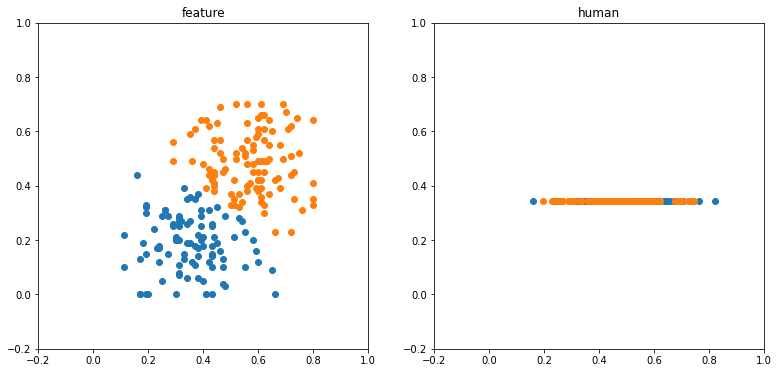

In [14]:
w11 = 2.7303
w12 = 10000
# xt = trans(x, y, w12, 1, 0, center=False)
# _ = plot(x, xt, [18, 6], [0, 1.4], [0, 0.7])
xt = trans(x, y, 1, 0, 'hard')
_ = plot(x, xt)

In [15]:
def ord_dist(a, b, order=2):
    order = np.array(order) if len(order) > 1 else order
    root = 2 if len(order) > 1 else order
    diff = a[:,np.newaxis].repeat(len(b),1) - b
    return (np.abs(diff)**order).sum(-1)**(1/root)

In [16]:
remb_dist = euc_dist(remb_test, remb_train)
remb_nn_i, remb_nn_p = get_nn(remb_dist)
eval(xt, remb_nn_p).mean()

0.55

In [17]:
human_test = xt[list(i2p_test.values())]
human_train = xt[list(i2p_train.values())]
human_dist = euc_dist(human_test, human_train)
human_nn_i, human_nn_p = get_nn(human_dist)
eval(xt, human_nn_p).mean()

0.425

In [18]:
eval_1nn(remb_dist).mean(), eval_1nn(human_dist).mean()

(0.975, 0.425)